# Budget Optimization by past performance


## Abstract
Today, billions of display ad impressions are purchased on a daily basis through direct buy. Restricted by the budget, the goal is to buy a set of ad impressions to reach as many targeted users or convertion KPI as possible. A desired action (conversion), advertiser specific, includes purchasing a product, filling out a form, signing up for emails, etc. 

Our algorithm tries to use expert's judgement as boudary inputs and select high quality impressions and adjust the budget allocation based on the prior performance distribution of placement.It combine tracking campaign performance at every convertion point and persuade to move more budget from low perform media to high perform media. 



通过追踪营销活动各关键节点的效果，我们能够总结高效营销活动的共性，以及可能降低活动效率的广告预算.

最终在数据积累到一定程度后，将其产品化、可视化，协助品牌建立独有的知识库。


## Problem Setup

In real scenario, a lot of media budget is locked at beginning of campaign. Some media is able to shift budget across media or within media, while some others don't allow.


meanwhile, sometime ads performance has exceptional scenario as below:
- publisher doesn't always deliver ads from 0h to 24h, sometime it's 9pm - 9pm
- Not scheduled traffic comming when publisher could not meet est impressions beacuse short of media inventory

Planner want to decide how much % of budget can increase/decrease by prior performance 

# Estimation of CTR and AR
Assume that we have a good system to accurately estimate click through rate (CTR) and action or conversion rate (AR). In this section, we will describe how to do this estimation. Again for simplicity and without loss of generality, we will focus on AR.

there many standard machine learning methods, e.g., logistic regressions are used to combine multiple AR estimates from different levels in the hierarchy to produce a final boosted estimate.

We use the methodology introduced above and make some improvements on the top of that. In this method, we would like to find the AR for each triplet combination of (publisher, advertiser) by leveraging the hierarchy structure of their features. Each actual creative (the graphic ad to be shown on the page) is a leaf in the advertiser tree hierarchy. The hierarchy starts with the root and continues layer after layer by advertiser category, advertiser, insertion order, package, line item, ad and finally reative. Using the historical data, one can assign an AR to each node in this tree by aggregating total number of impressions and actions
of their children as a raw estimate. Same hierarchy and raw estimations can be done for publisher and media format.

## The Fundamental Theorem of Linear Programming

A form of mathematical optimization that deals specifically with linear equations. Linear Programming is also known as Linear Optimization.
### Linear program
A linear program is a problem where a set of decisions need ot be made to optimize an objective in light of some constraints, where botht the constraints and the objective are linear.
### Objective Function
The objective function is what we are trying to optimize. Specifically, it is a linear equation whose dependent variable we are typically trying to either minimize or maximize.
### The Decisions
These are essentially the independent variables in our objective function. These repesent the decisions that we need to make. In the classic economic example, it would be the number of guns vs. amount of butter that we should produce.
### Constraints
The constraints in our linear program are represented as a set of linear inequalities that limit what decisions we can make.
### Polytype
A polytype is a geometric shape with flat sides. It is the multidimensional counterpart to the 2D polygon.

![](non_convex_polygon.png)

## Budget Optimization In Campaign Executing

In this section, we formulate the problem of Ads optimization as an **online linear programming**.

Assume there are n placements that belong to m medias in a campaign.

$ maximize_{Convertions} = \sum_{i=1}^n{ \frac{b_i}{CPM} * Convertion\%} $

$ S.t. $
  * $ \sum_{i=1}^n{b_i} = {Total Remaining Budget} $
  * $ \sum_{i=1}^{m_n}{b_{i,m}} <= B_m^{uplimit} ,  \forall m \in M$
  * $ \sum_{i=1}^{m_n}{b_{i,m}} >= B_m^{lowlimit},  \forall m \in M$
  * $ \sum_{i=1}^{m_n}{b_{i,m}} <= B_m^{current} + \delta_{up} * {Total Movable Budget} ,  \forall m \in M$
  * $ \sum_{i=1}^{m_n}{b_{i,m}} >= B_m^{current} - \delta_{low} * {Total Movable Budget},  \forall m \in M$
  * $eCPM<= \beta$
  
where:
1. sum of placement budget $b_i$ should not exceed Total Remaining Budget
2. sum of placement budget of media j should not exceed contraint $B_m^{uplimit}$
3. sum of placement budget of media j should above contraint $B_m^{lowlimit}$
4. each placement budget should not increase more than \delta_{up}
5. each placement budget should not decrease more than \delta_{down}
6. eCPM does not exceed the cap $\beta$


## REFERENCES
- [Real Time Bid Optimization with Smooth Budget Delivery in Online Advertising](http://wnzhang.net/share/rtb-papers/budget-smooth.pdf)

- [Budget Optimization for Online Advertising Campaigns with Carryover Effects](http://pages.stern.nyu.edu/~narchak/cmdp_for_budget_optimization.pdf)

## Acquire OTV placement performance from MB digital database
reference to fb product
http://baijiahao.baidu.com/s?id=1587302689628516686&wfr=spider&for=pc

In [5]:
import pyodbc
import pandas as pd
import numpy as np
import os
cnxn = pyodbc.connect('DRIVER={SQL Server};SERVER=mecshsql.database.windows.net,1433;DATABASE=datamart;UID=mercedes;PWD=1qaz!QAZ')
sql = """
               
WITH CTE_Schedule            
AS            
(            
 SELECT [Symphony_Placement_Id]            
  ,[Date]
  ,[Total_Est_Imp] as Daily_Est_Imp
  ,[Total_Est_Click] as Daily_Est_Clk
  ,[Net_Media_Cost_Per_Day] as Daily_Cost
 FROM [dbo].[MediaPlan_CampaignSpots]            
 WHERE client = 'mercedes' and [Symphony_Placement_Id] IS NOT NULL    
   
)            
,CTE_AdMaster_spot_Perf            
AS            
(            
 SELECT            
   [Symphony_Placement_Id]            
  ,[Date]            
  ,SUM([Imp]) AS Imp            
  ,SUM(Clk) AS Clk            
  ,SUM(Uimp) AS Uimp            
  ,SUM(Uclk) AS Uclk     
  ,SUM(visits) as visits    
  ,sum(visitDuration) as visitDuration    
  --,sum(visitDuration)/sum(visits) as AvgVisitDuration    
  ,sum(uniquePageviews) as uniquePageviews    
  ,sum(dailyVisitors) as dailyVisitors
  ,sum(EventCount) as EventCount
  ,sum(uniqueVisitor) as uniqueVisitor        
 FROM dbo.AdMaster_CampaignPlacements_Daily            
 WHERE Symphony_Placement_Id IS NOT NULL      
 GROUP BY [Symphony_Placement_Id],[Date]            
)            
SELECT            
  P1.Symphony_Camp_Id            
 ,P1.[Symphony_Placement_Id]   
 ,P1.Product
 ,P1.Campaign         
 ,P1.Media_Type            
 ,P1.Media            
 ,P1.Position            
 ,P1.Format 
 ,P1.[Size]     
 ,P1.[Target_Market]
 ,P1.[Spot_Type]    
 ,P1.[Ad_Type]
 ,P1.[Ad_Format]
 ,P2.Date
 ,P2.Daily_Est_Imp
 ,Daily_Est_Clk
 ,Daily_Cost
 ,[Buying_Type]         
 ,[Imp_Trackable]            
 ,[Click_Trackable]   
 ,P1.Total_Est_Imp         
 ,P1.Total_Est_Click  
 ,round(P1.[Net_Media_Cost],0) as Total_Cost
 ,CASE WHEN ISNULL(P4.[Impression],0)> 0       
       THEN P4.[Impression]       
    ELSE P5.[Imp]
    END AS [Imp]       
 ,P5.Uimp AS [uv]            
 ,CASE WHEN ISNULL(P4.[Click],0)> 0       
       THEN P4.[Click]       
    ELSE P5.[Clk]
   END AS [Click]       
 ,P5.[Uclk] AS [Clicker]                     
 ,p5.visits    
 ,p5.visitDuration    
 ,p5.uniquePageviews    
 ,p5.dailyVisitors             
FROM CTE_Schedule P2            
INNER JOIN [dbo].[MediaPlan_CampaignPlacements] P1            
ON P1.[Symphony_Placement_Id]=P2.[Symphony_Placement_Id]                       
LEFT JOIN [dbo].[Untrackable_CampaignPerformance] P4            
ON P2.[Symphony_Placement_Id]=P4.[Symphony_Placement_Id] AND P2.Date=P4.Date          
LEFT JOIN CTE_AdMaster_spot_Perf P5            
ON P2.[Symphony_Placement_Id]=P5.[Symphony_Placement_Id] AND P2.Date=P5.Date           
where imp >1000 
ORDER BY DATE

"""
fn_data='mbdata.csv'
if not os.path.exists(fn_data):
    df_plac_perf = pd.read_sql(sql,cnxn)
    df_plac_perf.to_csv(fn_data, index=False, encoding='utf-8')
else:
    df_plac_perf= pd.read_csv(fn_data, encoding='utf-8')



In [6]:
df_plac_perf.Symphony_Placement_Id.unique().shape

(240,)

In [7]:
print("total %d rows, %d columns"% df_plac_perf.shape)
cnt_cmp, cnt_plcm = df_plac_perf.Symphony_Camp_Id.unique().shape[0],df_plac_perf.Symphony_Placement_Id.unique().shape[0]
print("total %d campaigns, %d placements"% (cnt_cmp, cnt_plcm ))
df_plac_perf.dtypes

total 3608 rows, 31 columns
total 18 campaigns, 240 placements


Symphony_Camp_Id                 object
Symphony_Placement_Id            object
Product                          object
Campaign                         object
Media_Type                       object
Media                            object
Position                         object
Format                           object
Size                             object
Target_Market                    object
Spot_Type                        object
Ad_Type                          object
Ad_Format                        object
Date                     datetime64[ns]
Daily_Est_Imp                   float64
Daily_Est_Clk                   float64
Daily_Cost                      float64
Buying_Type                      object
Imp_Trackable                      bool
Click_Trackable                    bool
Total_Est_Imp                     int64
Total_Est_Click                   int64
Total_Cost                      float64
Imp                             float64
uv                                int64


## DATA PROCESS
- **find high frequency words from position/format/size**
- additional features
- guess missing value on Spot_Type/ Ad_Type/ Ad_Format
- remove outlier


In [8]:
# 对广告位描述分词
from sklearn import feature_extraction
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
import jieba
import jieba.analyse as jieba_analyse
import jieba.posseg as pseg
import re

jieba_analyse.set_stop_words('stopwords.txt') 
jieba.load_userdict('userdict.txt')

# jieba.add_word('中大型')
datas = []
df_plac_unique = df_plac_perf.groupby('Symphony_Placement_Id').first().reset_index()

df_wcut = df_plac_unique[['Format','Position']]
corpus = ['{0},{1}'.format(fmt,pos) for fmt,pos in df_wcut.values]

def clean_str(myword):
    myword = re.sub('\d+$', '', myword)
    return myword

for oneline in corpus:
    seg_list = pseg.cut(oneline)
#     print([",".join(w) for w in seg_list ])
    words = [clean_str(w) for w,c in seg_list if c not in ['v','x','f','d','p'] and len(w)>1 and not w.isnumeric()]
    
    datas.append(" ".join(words))
datas[-5:]

Building prefix dict from the default dictionary ...
DEBUG:jieba:Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\yu.pan\AppData\Local\Temp\jieba.cache
DEBUG:jieba:Loading model from cache C:\Users\yu.pan\AppData\Local\Temp\jieba.cache
Loading model cost 1.019 seconds.
DEBUG:jieba:Loading model cost 1.019 seconds.
Prefix dict has been built succesfully.
DEBUG:jieba:Prefix dict has been built succesfully.


['某支 PC Mobile OTT 视频 播放页',
 'Banner 轮播 爱卡 首页',
 '紧凑型 SUV 型车 所有 车系 Button 紧凑型 SUV 型车',
 '开机 启动 广告 电视 盒子 开机 图片 小米 电视 盒子',
 '信息流 微动 广告 GD 时段 固定 cpm 形式 下单 后才 实际 库存 频道']

In [9]:
df_wcut.tail()

,Format,Position
235,30秒前贴【购买《我想和你唱》某支40%轮替】,PC+Mobile+OTT-视频播放页
236,右侧Banner03（1/2轮播）,爱卡首页
237,紧凑型SUV型车所有车系页右侧Button,紧凑型SUV型车
238,开机启动广告-电视盒子-开机图片,小米电视/盒子
239,信息流微动广告-GD分时段：11:00-23:59（非固定位置，cpm形式，下单后才可锁量，...,推荐频道


In [10]:
# 计算tfidf
freWord = CountVectorizer()
#统计每个词语的tf-idf权值
transformer = TfidfTransformer()
#计算出tf-idf(第一个fit_transform),并将其转换为tf-idf矩阵(第二个fit_transformer)
tfidf = transformer.fit_transform(freWord.fit_transform(datas))

#获取词袋模型中的所有词语
word = freWord.get_feature_names()
#得到权重
weight = tfidf.toarray()
tfidfDict = {}
for i in range(len(weight)):
    for j in range(len(word)):
        getWord = word[j]
        
        getValue = weight[i][j]
        
        if getValue != 0:
            if tfidfDict.get(getWord):
                tfidfDict[getWord] += getValue
                
            else:
                tfidfDict.update({getWord:getValue})

In [11]:
# tfidf 排序
sorted_tfidf = sorted(tfidfDict.items(),key = lambda d:d[1],reverse = True)
sorted_tfidf[:10]

[('通栏', 24.00553199080943),
 ('首页', 22.457527988490682),
 ('论坛', 14.511999300305257),
 ('车型', 13.687169595638535),
 ('页面', 10.761070776471314),
 ('视频', 10.641972823046137),
 ('pc', 10.419247493003244),
 ('suv', 9.859086627095051),
 ('频道', 9.499349306580982),
 ('汽车', 8.45228330907449)]

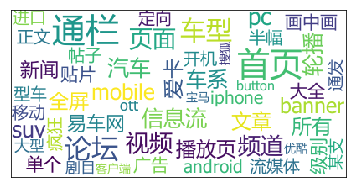

In [12]:
# 词云
%matplotlib inline
import matplotlib.pyplot as plt
from scipy.misc import imread
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
# from wordcloud_cn import WordCloud_CN

wc_fname = "%s.png"%('md_ads')
wc = WordCloud(font_path='msyh.ttf',
                background_color="white", max_words=50,
                max_font_size=40, random_state=42)

wc.generate_from_frequencies(tfidfDict)

fig = plt.imshow(wc.recolor())
fig.axes.get_xaxis().set_visible(False)
fig.axes.get_yaxis().set_visible(False)

In [13]:
df_words = pd.DataFrame(tfidf.todense(), columns= word)
df_plac_unique = pd.concat([df_plac_unique,df_words], axis=1)

topn_words= df_words.sum().sort_values(ascending=False)[:100].index



## DATA PROCESS
- find high frequency words from position/format/size
- **additional features**
    - cluster by kenwords
    - quantile by cost
    - last 3/20 days ctr
    - fake leads
- guess missing value on Spot_Type/ Ad_Type/ Ad_Format
- remove outlier


In [14]:
# 文本分类

from PIL import Image,ImageDraw
import os, codecs, random
from math import sqrt
from sklearn.cluster import k_means, dbscan

# clusters = dbscan(df_words,eps=.5, min_samples=2)
clusters = k_means(df_words,n_clusters=50)
clusters[1].shape
print('cluster to %d categories' % len(np.unique(clusters[1])))

cluster to 50 categories


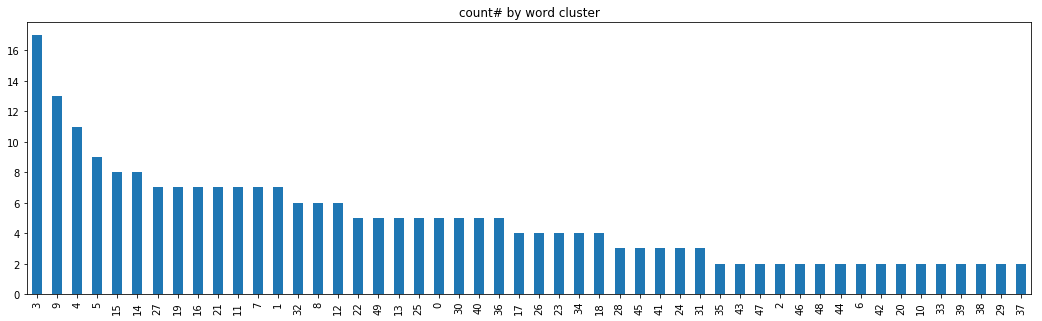

In [15]:

df_plac_unique['word_cluster'] = clusters[1]

df_topn_words = df_plac_unique[np.concatenate((np.array(['Symphony_Placement_Id','word_cluster']), topn_words), axis=0)]
df_plcm_words = df_plac_perf.merge(df_plac_unique[['Symphony_Placement_Id','word_cluster']], on ='Symphony_Placement_Id')

df_plac_unique['word_cluster'].value_counts().plot(kind='bar', title='count# by word cluster', figsize=(18,5));

In [16]:
display('top 5 keywords in each cluster:')
df_cluster = df_plac_unique.groupby(['Media_Type','word_cluster']).size().sort_values(ascending = False)
for clusterNo, cnt in df_cluster[:30].iteritems():
    df_winc = df_topn_words[(df_plac_unique.Media_Type==clusterNo[0]) &(df_plac_unique.word_cluster==clusterNo[1])].drop(['Symphony_Placement_Id','word_cluster'],axis=1).sum().sort_values(ascending=False)
    print('cluster %s(%s):'%(str(clusterNo), cnt) + ','.join(list(df_winc[df_winc>0].head(10).index)))
    

'top 5 keywords in each cluster:'

cluster ('Auto', 3)(17):论坛,单个,帖子,正文,车型,宝马,通栏,奥迪,amg
cluster ('Auto', 9)(13):级别,大全,页面,汽车,车系,suv,车型,通栏,中型车,论坛
cluster ('Auto', 4)(9):首页,通栏,爱卡,新车,触发式,评测,巨幕,广告
cluster ('Auto', 5)(9):所有,大型,型车,suv,尺寸,车系,通栏,车型,紧凑型,中型车
cluster ('Auto', 15)(8):疯狂,流媒体,爱卡,首页
cluster ('Finance', 14)(8):画中画,半幅,pc,文章,首页,所有
cluster ('Auto', 7)(7):页面,车型,通栏,触发式
cluster ('Video', 27)(7):优酷,播放页,视频,pc,前贴,剧目,mobile,移动,mo
cluster ('Auto', 16)(7):进口,综述,单一,易车网,车型,通栏,amg,奥迪,宝马
cluster ('Finance', 11)(7):全屏,开机,iphone,android,首页,mobile,pc
cluster ('Auto', 1)(7):频道,通栏,suv,首页,新车
cluster ('Video', 12)(6):ott,某支,播放页,mobile,pc,视频,剧场
cluster ('Portal', 19)(6):搜狐,新闻,首页,app,频道,通发,视频,客户端,广告,信息流
cluster ('Auto', 8)(5):文章,所有,页面,suv,通栏
cluster ('Finance', 25)(5):top,banner,iphone,android,mobile,通栏
cluster ('Auto', 21)(5):banner,首页,爱卡,轮播,评测
cluster ('Auto', 30)(5):button,首页,紧凑型,评测,文章,爱卡,新闻,所有,车系
cluster ('Auto', 32)(5):轮播,首页,通栏,按钮
cluster ('Lifestyle', 36)(5):广告,全屏,咖啡厅
cluster ('Video', 13)(5):贴片,腾讯,双屏,mo,定向,视频,pc,剧目,cpm,移动
cluster ('Video'

timeseries statistic


In [17]:
# cummulated numbers
# cost
import warnings
warnings.filterwarnings('ignore')
def add_ts_features(df_plac_perf):
    df_cum_cost= df_plac_perf.set_index(['Symphony_Placement_Id','Date']).groupby(level=0)['Daily_Cost'].transform(lambda g: g.shift(1).cumsum()).rename('Cum_Daily_Cost').to_frame().reset_index()
    df_plac_perf = pd.merge(df_plac_perf, df_cum_cost, on = ['Symphony_Placement_Id','Date'])
    # imp
    df_cum_cost= df_plac_perf.set_index(['Symphony_Placement_Id','Date']).groupby(level=0)['Imp'].transform(lambda g: g.shift(1).cumsum()).rename('Cum_Imp').to_frame().reset_index()
    df_plac_perf = pd.merge(df_plac_perf, df_cum_cost, on = ['Symphony_Placement_Id','Date'])
    # clk
    df_cum_cost= df_plac_perf.set_index(['Symphony_Placement_Id','Date']).groupby(level=0)['Click'].transform(lambda g: g.shift(1).cumsum()).rename('Cum_Click').to_frame().reset_index()
    df_plac_perf = pd.merge(df_plac_perf, df_cum_cost, on = ['Symphony_Placement_Id','Date'])
    # clk
    df_cum_cost= df_plac_perf.set_index(['Symphony_Placement_Id','Date']).groupby(level=0)['uv'].transform(lambda g: g.shift(1).cumsum()).rename('Cum_uv').to_frame().reset_index()
    df_plac_perf = pd.merge(df_plac_perf, df_cum_cost, on = ['Symphony_Placement_Id','Date'])
    # visits
    df_cum_visits= df_plac_perf.set_index(['Symphony_Placement_Id','Date']).groupby(level=0)['visits'].transform(lambda g: g.shift(1).cumsum()).rename('Cum_visits').to_frame().reset_index()
    df_plac_perf = pd.merge(df_plac_perf, df_cum_visits, on = ['Symphony_Placement_Id','Date'])    
    # visit duration
    df_cum_visitsDur= df_plac_perf.set_index(['Symphony_Placement_Id','Date']).assign(avgDur = lambda o: o.visitDuration / o.visits) \
            .groupby(level=0)['avgDur'].transform(lambda g: g.shift(1).rolling(10, min_periods=1).mean()).rename('avgDur').to_frame().reset_index()
    df_plac_perf = pd.merge(df_plac_perf, df_cum_visitsDur, on = ['Symphony_Placement_Id','Date'])   
    ## calculate
    df_plac_perf['Cum_CTR'] = df_plac_perf['Cum_Click']/df_plac_perf['Cum_Imp'] * 100
    df_plac_perf['Cum_CPM'] = df_plac_perf['Cum_Daily_Cost']/(df_plac_perf['Cum_Imp'] / 1000)
    df_plac_perf['Imp_Complete%'] = df_plac_perf['Cum_Imp'] / df_plac_perf['Total_Est_Imp']
    df_plac_perf['Imp%'] = df_plac_perf['Daily_Cost'] / df_plac_perf['Total_Cost']
    df_plac_perf['Cum_Imp2Visits'] = df_plac_perf['Cum_visits'] / df_plac_perf['Cum_Imp']

    # last 3d
    df_mediactr = df_plac_perf.groupby(['Media','Date'])['Media','Date','Cum_Imp','Cum_Click'].sum()
    df_mediactr = df_mediactr.groupby(level=0).apply(lambda g: g.shift(1).rolling(10, min_periods=1).mean()).assign(Avg_CTR_last3d = lambda o:o.Cum_Click/ o.Cum_Imp *100 )
    df_mediactr = df_mediactr.groupby(level=0).apply(lambda g: g.shift(1).rolling(10, min_periods=1).mean()).assign(Avg_CTR_last10d = lambda o:o.Cum_Click/ o.Cum_Imp *100 )
    df_mediactr = df_mediactr.drop(['Cum_Imp','Cum_Click'], axis=1).reset_index()
    df_plac_perf = pd.merge(df_plac_perf, df_mediactr, on = ['Media','Date'])
    
    df_plac_perf['CTR'] =  df_plac_perf['Click'] / df_plac_perf['Imp'] * 100
    df_plac_perf['Est_CTR']  =  df_plac_perf['Total_Est_Click'] / df_plac_perf['Total_Est_Imp'] * 100
    df_plac_perf['Est_CPM']  =  df_plac_perf['Daily_Cost'] / (df_plac_perf['Total_Est_Imp'] /1000)
    df_plac_perf['Is_Free'] = (df_plac_perf['Daily_Cost']==0).astype(np.int)
    return df_plac_perf

df_featured = add_ts_features(df_plcm_words)

[col for col in df_featured.columns if col.startswith('Cum') or col.startswith('Avg')]


['Cum_Daily_Cost',
 'Cum_Imp',
 'Cum_Click',
 'Cum_uv',
 'Cum_visits',
 'Cum_CTR',
 'Cum_CPM',
 'Cum_Imp2Visits',
 'Avg_CTR_last3d',
 'Avg_CTR_last10d']

In [18]:
df_featured[['Symphony_Placement_Id','Date','Click','Cum_Click']].sort_values(['Symphony_Placement_Id','Date']).head()

,Symphony_Placement_Id,Date,Click,Cum_Click
1765,1043816746-1895941382-1166989262-33,2017-06-16,76.0,NaN
2840,1043816746-1895941382-1166989262-33,2017-06-19,96.0,76.0
2842,1043816746-1895941382-1166989262-33,2017-06-20,101.0,172.0
2844,1043816746-1895941382-1166989262-33,2017-06-21,52.0,273.0
1781,1043816746-1895941382-1166989262-33,2017-06-22,90.0,325.0


(0, 15)

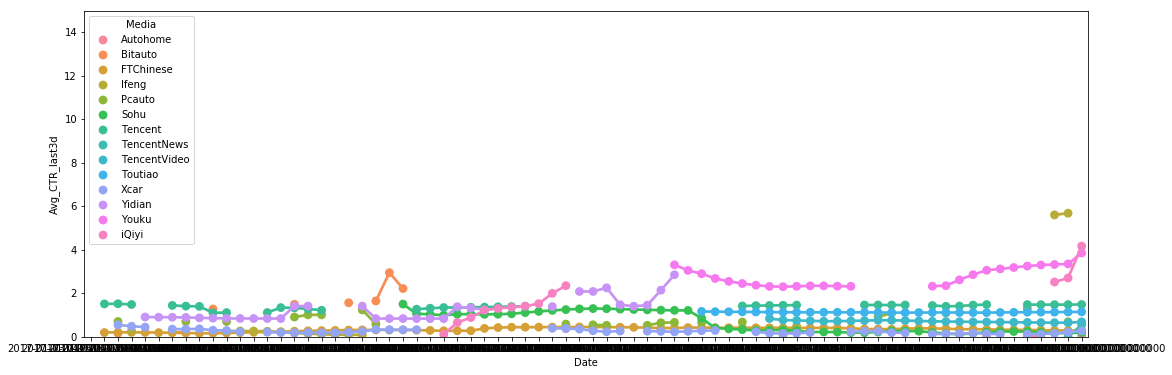

In [19]:
import seaborn as sns
sns.color_palette('Set1')
plt.figure(figsize=(18,6))
df_mediactr = df_featured.groupby(['Media','Date'])['Media','Date','Cum_Imp','Cum_Click'].mean()
df_mediactr = df_mediactr.groupby(level=0).apply(pd.rolling_mean, 3, min_periods=1).assign(Avg_CTR_last3d = lambda o:o.Cum_Click/ o.Cum_Imp *100 )
df_mediactr = df_mediactr.reset_index()
sns.pointplot(data=df_mediactr[df_mediactr.Date<'2017-03-18'], x='Date', y ='Avg_CTR_last3d', hue='Media')
plt.ylim([0,15])


## Data Exploration

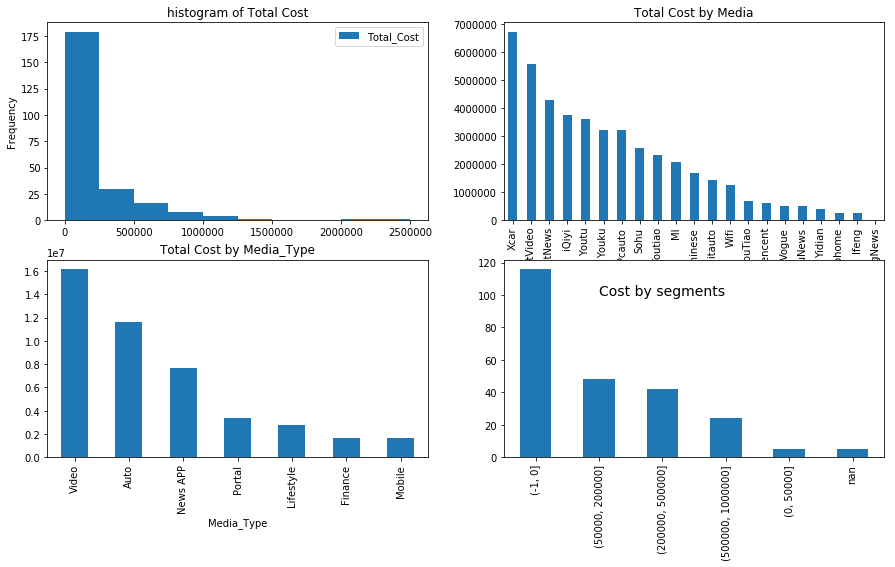

In [20]:
# segment cost; visual

df_plac_perf['Total_Cost']=df_plac_perf.Total_Cost.fillna(0)
df_plac_perf['qcost'] = pd.cut( df_plac_perf.Total_Cost, [-1,0,50000,200000,500000, 1000000]).astype(str)

df_plac_agg = df_plac_perf.groupby(['Symphony_Placement_Id']).max()
fig, axarr = plt.subplots(2,2, figsize=(15,8))

ax1 = df_plac_agg.plot(kind='hist', x= 'Media',y='Total_Cost', title='histogram of Total Cost', ax=axarr[0,0])

ax2 = df_plac_agg.groupby('Media')['Total_Cost'].sum().sort_values(ascending=False).plot(kind='bar',x='Media',y='Total_Cost', title='Total Cost by Media',ax=axarr[0,1])

df_plac_agg.groupby('Media_Type')['Total_Cost'].sum().sort_values(ascending=False).plot(kind='bar',x='Media_Type',y='Total_Cost', title='Total Cost by Media_Type',ax=axarr[1,0])

df_plac_agg['qcost'].value_counts().plot(kind='bar',ax=axarr[1,1])
plt.text(1,100,'Cost by segments', fontsize=14);

## correct non-normal distribution 

Text(0.5,1,'Probplot against normal distribution')

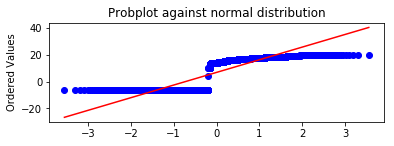

In [21]:
from scipy import stats
df_featured.loc[df_featured.Total_Cost <=0 , 'Total_Cost'] = 0.001
df_featured['Total_Cost_Log'] = stats.boxcox(df_featured.Total_Cost)[0]
fig = plt.figure()
ax1 = fig.add_subplot(211)

prob = stats.probplot(df_featured.Total_Cost_Log, dist=stats.norm, plot=ax1)
ax1.set_xlabel('')
ax1.set_title('Probplot against normal distribution')

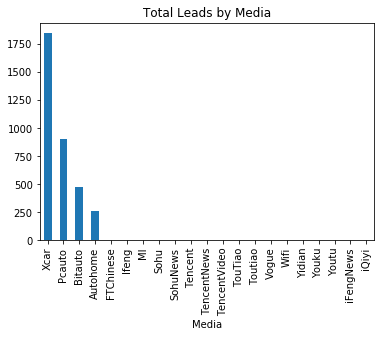

In [22]:
# add leads for Auto media with cost
# df_plac_perf.loc[df_plac_perf['Media_Type']=='Auto',['Imp','clk','Daily_Cost','Total_Cost','visitor']]
df_plac_auto = df_plac_perf.loc[df_plac_perf['Media_Type']=='Auto']
df_plac_perf.loc[df_plac_perf['Media_Type']=='Auto','Leads']=np.round(df_plac_auto.Imp*np.random.standard_gamma(2,df_plac_auto.shape[0])/500000,0)
df_plac_perf.groupby('Media')['Leads'].sum().sort_values(ascending=False).plot(kind='bar',x='Media',y='Leads', title='Total Leads by Media')

In [23]:
df_featured.to_csv('mbdatapp.csv')

<script>
  jQuery(document).ready(function($) {

  $(window).load(function(){
    $('#preloader').fadeOut('slow',function(){$(this).remove();});
  });

  });
</script>

<style type="text/css">
  div#preloader { position: fixed;
      left: 0;
      top: 0;
      z-index: 999;
      width: 100%;
      height: 100%;
      overflow: visible;
      background: #fff url('http://preloaders.net/preloaders/720/Moving%20line.gif') no-repeat center center;
  }

</style>

<div id="preloader"></div>

## how expensive of word cluster?

In [24]:
df_wdone= df_featured.select(lambda x: x.endswith('__'),axis=1).applymap(lambda x: 1 if x>0 else 0)
df_featured[df_wdone.columns] = df_wdone

# df_featured[df_wdone.columns].sum(axis=0).sort_values(ascending=False)
df_wdcmt = df_plac_unique.groupby(['Media_Type','word_cluster'])['Total_Cost'].mean().reset_index().fillna(0)
# df_wdcmt
# f, ax = plt.subplots(figsize = (10, 4))
# cmap = sns.cubehelix_palette(start = 1, rot = 3, gamma=0.8, as_cmap = True)
# sns.heatmap(df_wdcmt, cmap = cmap, linewidths = 0.05, ax = ax)

## Build Estimator

In [25]:
df_featured[df_featured.Date>='2017-08-01']

,Symphony_Camp_Id,Symphony_Placement_Id,Product,Campaign,Media_Type,Media,Position,Format,Size,Target_Market,...,Imp_Complete%,Imp%,Cum_Imp2Visits,Avg_CTR_last3d,Avg_CTR_last10d,CTR,Est_CTR,Est_CPM,Is_Free,Total_Cost_Log
3101,2095790581-1120606724,2095790581-1120606724-361596326-34,Dream Car,2017 Dream Car Campaign,Lifestyle,Wifi,B类咖啡厅,全屏广告,手机端：300*300，Htlm5＜300K，8秒，不能含声音,None,...,0.413639,NaN,0.045602,7.062287,7.080254,6.951079,7.0,0.000000,1,-6.032581
3102,2095790581-1120606724,2095790581-1120606724-1622785313-33,Dream Car,2017 Dream Car Campaign,Lifestyle,Wifi,太平洋咖啡厅 Costa,全屏广告,手机端：300*300，Htlm5＜300K，8秒，不能含声音,None,...,0.380068,0.021608,0.057461,7.062287,7.080254,7.216350,7.0,7.776519,0,16.418010
3103,2095790581-1120606724,2095790581-1120606724-1403902596-30,Dream Car,2017 Dream Car Campaign,Lifestyle,Wifi,星巴克（江浙沪）,全屏广告,手机端：300*300，Htlm5＜300K，8秒，不能含声音,None,...,0.347823,0.023020,0.037983,7.062287,7.080254,8.181280,7.0,8.285007,0,16.118591
3104,2095790581-1120606724,2095790581-1120606724-1373177117-32,Dream Car,2017 Dream Car Campaign,Lifestyle,Wifi,机场（深圳，天津，杭州）,全屏广告,手机端：300*300，Htlm5＜300K，8秒，不能含声音,None,...,0.519871,0.027648,0.047335,7.062287,7.080254,7.763016,7.0,9.950599,0,14.245390
3105,2095790581-1120606724,2095790581-1120606724-361596326-34,Dream Car,2017 Dream Car Campaign,Lifestyle,Wifi,B类咖啡厅,全屏广告,手机端：300*300，Htlm5＜300K，8秒，不能含声音,None,...,0.439695,NaN,0.045471,7.059121,7.072485,6.965337,7.0,0.000000,1,-6.032581
3106,2095790581-1120606724,2095790581-1120606724-1622785313-33,Dream Car,2017 Dream Car Campaign,Lifestyle,Wifi,太平洋咖啡厅 Costa,全屏广告,手机端：300*300，Htlm5＜300K，8秒，不能含声音,None,...,0.405621,0.021608,0.057295,7.059121,7.072485,7.375271,7.0,7.776519,0,16.418010
3107,2095790581-1120606724,2095790581-1120606724-1403902596-30,Dream Car,2017 Dream Car Campaign,Lifestyle,Wifi,星巴克（江浙沪）,全屏广告,手机端：300*300，Htlm5＜300K，8秒，不能含声音,None,...,0.377000,0.023020,0.038605,7.059121,7.072485,8.644254,7.0,8.285007,0,16.118591
3108,2095790581-1120606724,2095790581-1120606724-1373177117-32,Dream Car,2017 Dream Car Campaign,Lifestyle,Wifi,机场（深圳，天津，杭州）,全屏广告,手机端：300*300，Htlm5＜300K，8秒，不能含声音,None,...,0.579530,0.027648,0.049468,7.059121,7.072485,7.782342,7.0,9.950599,0,14.245390
3109,2095790581-1120606724,2095790581-1120606724-361596326-34,Dream Car,2017 Dream Car Campaign,Lifestyle,Wifi,B类咖啡厅,全屏广告,手机端：300*300，Htlm5＜300K，8秒，不能含声音,None,...,0.465944,NaN,0.045549,7.057268,7.071811,6.935604,7.0,0.000000,1,-6.032581
3110,2095790581-1120606724,2095790581-1120606724-1622785313-33,Dream Car,2017 Dream Car Campaign,Lifestyle,Wifi,太平洋咖啡厅 Costa,全屏广告,手机端：300*300，Htlm5＜300K，8秒，不能含声音,None,...,0.431078,0.021608,0.057100,7.057268,7.071811,7.244854,7.0,7.776519,0,16.418010


In [29]:
from sklearn.linear_model import Lasso

def to_dftrain(df_featured):
    drop_cols = ['Click','Cum_Click','Symphony_Camp_Id','Symphony_Placement_Id','Campaign','Position','Format','Size'\
                ,'Date','Target_Market','Clicker','Imp','visitDuration','visits','dailyVisitors','uniquePageviews'\
                ,'uv','Ad_Format','Ad_Type','Media_Type','Spot_Type','Buying_Type','Total_Est_Click']
    df_train = df_featured.drop(drop_cols, axis=1)
    
    df_train = df_train.drop(df_wdone.columns, axis=1)
    df_train = df_train[df_train['CTR']<25]
    df_train = df_train[df_train.Est_CTR!=np.inf]
    df_train = df_train.fillna(0)
    df_train = df_train[df_train['Imp_Complete%']!=np.inf]
    df_train['word_cluster'] = df_featured.word_cluster.apply(lambda x: 'C'+str(x))
    return df_train

df_featured = df_featured[df_featured.Daily_Cost>0]

df_train = to_dftrain(df_featured[df_featured.Date<'2017-08-01'])
df_test = to_dftrain(df_featured[df_featured.Date>='2017-08-01'])

# md_lso = Lasso(selection ='random')
# md_lso.fit(df_X,df_y)
from auto_ml import predictor
column_descriptions = {'CTR':'output'}
pred = predictor.Predictor('regressor', column_descriptions=column_descriptions)
pred.train(df_train,model_names= ['LGBMRegressor'], perform_feature_scaling = True)
# pred.train_categorical_ensemble(df_train,'Product',model_names= ['LogisticRegression'], perform_feature_scaling = True)

Welcome to auto_ml! We're about to go through and make sense of your data using machine learning, and give you a production-ready pipeline to get predictions with.

If you have any issues, or new feature ideas, let us know at http://auto.ml
You are running on version 2.9.10
Now using the model training_params that you passed in:
{}
After overwriting our defaults with your values, here are the final params that will be used to initialize the model:
{'n_estimators': 2000, 'learning_rate': 0.15, 'num_leaves': 8, 'lambda_l2': 0.001, 'histogram_pool_size': 16384}
Running basic data cleaning
could not convert string to float: 'G-Class'
could not convert string to float: 'S-Class'
could not convert string to float: 'G-Class'
could not convert string to float: 'S-Class'
could not convert string to float: 'AMG 63'
could not convert string to float: 'S-Class'
could not convert string to float: 'smart'
could not convert string to float: 'S-Class'
could not convert string to float: 'R-Class'
could

Finished training the pipeline!
Total training time:
0:00:00


Here are the results from our LGBMRegressor
predicting CTR
Calculating feature responses, for advanced analytics.
The printed list will only contain at most the top 100 features.
+---------+-----------------+--------------+--------------+-------------------+-------------------+-----------+-----------+-----------+-----------+
|         | Feature Name    |   Importance |        Delta |   FR_Decrementing |   FR_Incrementing |   FRD_abs |   FRI_abs |   FRD_MAD |   FRI_MAD |
|---------+-----------------+--------------+--------------+-------------------+-------------------+-----------+-----------+-----------+-----------|
| 25.0000 | word_cluster    |            0 |       0.0000 |            0.0000 |            0.0000 |    0.0000 |    0.0000 |    0.0000 |    0.0000 |
| 23.0000 | Media           |            0 |       0.0000 |            0.0000 |            0.0000 |    0.0000 |    0.0000 |    0.0000 |    0.0000 |
| 22.0000 | Imp_Tr

In [33]:
from sklearn.metrics import r2_score, mean_absolute_error

y_hat = np.array(pred.predict(df_train))
y_hat[y_hat<=0] = 0.005

s1 = r2_score(df_train.CTR, y_hat)
s2 = mean_absolute_error(df_train.CTR, y_hat)
print('r2 = %f, mae=%f' %(s1, s2))

r2 = 0.952522, mae=0.255244


In [34]:
df_score = df_train[['Daily_Cost','CTR']]

df_score['estimate_CTR'] = y_hat
df_score.tail(10)

,Daily_Cost,CTR,estimate_CTR
3432,27200.00,0.625561,0.449256
3466,27978.67,6.660547,8.741488
3467,27978.67,7.942594,9.367812
3468,45000.00,0.199973,0.017000
3469,45000.00,0.195096,0.256103
3470,45000.00,0.177205,0.700590
3471,45000.00,0.256126,0.249909
3472,45000.00,0.265735,0.249909
3473,45000.00,0.272096,0.249909
3474,45000.00,0.282131,0.249909


In [35]:
# validate test dataset
y_hat = np.array(pred.predict(df_test))
y_hat[y_hat<=0] = 0.005

s1 = r2_score(df_test.CTR, y_hat)
s2 = mean_absolute_error(df_test.CTR, y_hat)
print('r2 = %f, mae=%f' %(s1, s2))

r2 = 0.861440, mae=1.058755


## recommend optimized portrlio using Lininear Programing



In [36]:
df_test = df_featured[df_featured.Symphony_Camp_Id=='1828209496-1870683676']

df_test = df_test[(df_test.Date<= '2017-01-17') & (df_test.Total_Cost>0)]

last_day = df_test.Date.sort_index().iloc[-1]
df_last_day = df_test.groupby(['Symphony_Placement_Id']).last()
df_last_day['Symphony_Placement_Id'] = df_last_day.index
df_last_day['remaining_budget'] = (df_last_day.Total_Cost - df_last_day.Cum_Daily_Cost).fillna(0)
remaining_cost = df_last_day.remaining_budget.sum()
df_last_day['remaining_pct'] = (df_last_day.remaining_budget/remaining_cost)
df_last_day['original_pct'] = df_last_day['remaining_pct'].map(lambda x: '%.2f %%'%(x*100))
print('remaining_cost:' + str(remaining_cost))


remaining_cost:633574.738131


In [37]:
df_test = to_dftrain(df_last_day)
pred_ctr = np.array(pred.predict(df_test))
pred_ctr

array([0.40887601, 0.43255723, 0.23952208, 1.33942409, 0.62841822,
       0.35528781, 1.52621956, 1.00770949, 0.93524508, 1.19478673,
       0.54441691, 1.03320227, 0.87503679, 0.48618833])

In [38]:
for i,r in df_last_day.iterrows():
    df_last_day.loc[i,'mix_cpm'] = r['Est_CPM'] if np.isnan(r['Cum_CPM']) else r['Cum_CPM']
    

In [39]:
from pulp import *

# initialize the model maximize conversion rate 
marketing_budget = pulp.LpProblem('Pay Per Click Budget Optimization', pulp.LpMaximize)

# list of ppc providers
ppc_providers = df_last_day.Symphony_Placement_Id.unique()

# the decision variables that will be spend in every ppc provider 
x = pulp.LpVariable.dict('x_%s', ppc_providers, lowBound =0)


total_budget= 10000.0
# average cost per click by ppc provider 0.55 eurs etc
avg_cpm = dict(zip(df_last_day.index, df_last_day.mix_cpm.values))

# average conversion rates by ppc provider
avg_conv_rate = dict(zip(df_last_day.index, pred_ctr)) # df_last_day.Cum_CTR.fillna(0)

# objective function max conversion rates
marketing_budget += sum([ (x[i]*total_budget/avg_cpm[i])*avg_conv_rate[i] for i in ppc_providers])

# total budget constraint < 1800 euros
marketing_budget += sum([ x[i] for i in ppc_providers]) <= 1

# adwords search contstraing  equal or less than 500 euros
up_bound = df_last_day['remaining_pct'].map(lambda z: 0.5 if z+.1>0.5 else z+.1)
low_bound = df_last_day['remaining_pct'].map(lambda z: z-0.1 if z-.1>0 else 0)

for plcm in df_last_day.index:
    marketing_budget += x[plcm] >= low_bound[plcm]
    marketing_budget += x[plcm] <= up_bound[plcm]
    


#we using the default solver
marketing_budget.solve()

#print the result
for ppc_provider in ppc_providers:
    df_last_day.loc[ppc_provider,'ai_pct'] = x[ppc_provider].value()*100
    df_last_day.loc[ppc_provider,'optimized_pct'] = '%.2f %%' % (x[ppc_provider].value()*100)
    print('The amount of euros for %s is %.2f %% '%(ppc_provider,x[ppc_provider].value()*100))

The amount of euros for 1828209496-1870683676-1029679998-34 is 0.00 % 
The amount of euros for 1828209496-1870683676-1352125098-54 is 20.80 % 
The amount of euros for 1828209496-1870683676-1396203630-60 is 10.44 % 
The amount of euros for 1828209496-1870683676-1525904507-25 is 50.00 % 
The amount of euros for 1828209496-1870683676-1724252376-47 is 0.00 % 
The amount of euros for 1828209496-1870683676-1742826194-61 is 10.44 % 
The amount of euros for 1828209496-1870683676-1766946681-23 is 0.00 % 
The amount of euros for 1828209496-1870683676-2060653125-57 is 0.00 % 
The amount of euros for 1828209496-1870683676-2100403259-58 is 0.00 % 
The amount of euros for 1828209496-1870683676-317842789-56 is 0.00 % 
The amount of euros for 1828209496-1870683676-331905669-59 is 0.00 % 
The amount of euros for 1828209496-1870683676-344419667-48 is 0.00 % 
The amount of euros for 1828209496-1870683676-509202284-46 is 8.31 % 
The amount of euros for 1828209496-1870683676-751771387-55 is 0.00 % 


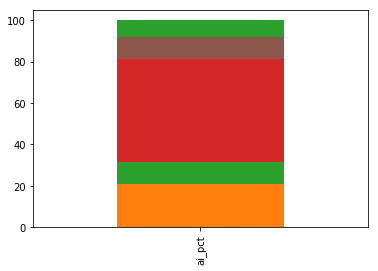

In [40]:
df_last_day[['ai_pct']].transpose().plot.bar(stacked=True, legend=False);



In [43]:
df_last_day[['original_pct','optimized_pct']].head()

,original_pct,optimized_pct
Symphony_Placement_Id,,
1828209496-1870683676-1029679998-34,0.00 %,0.00 %
1828209496-1870683676-1352125098-54,30.80 %,20.80 %
1828209496-1870683676-1396203630-60,0.44 %,10.44 %
1828209496-1870683676-1525904507-25,45.45 %,50.00 %
1828209496-1870683676-1724252376-47,0.00 %,0.00 %
